In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')  # Ensure TF does not see GPU and grab all GPU memory.
tf.random.set_seed(42)  # For reproducibility.

from quantum_transformers.datasets import get_mnist_dataloaders, get_quark_gluon_dataloaders, get_electron_photon_dataloaders

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

2023-11-04 12:10:28.293714: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 12:10:28.293742: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 12:10:28.293770: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-04 12:10:28.302959: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 12:10:30.005055: W tensorflow/compiler/

In [2]:
def get_one_and_avg(dataloaders, num_classes):
    ones = [None] * num_classes
    avgs = [None] * num_classes
    ns = [0] * num_classes

    for dataloader in dataloaders:
        for X, y in dataloader:
            X, y = np.squeeze(X), y[0]
            if ones[y] is None:
                ones[y] = X.copy()
                avgs[y] = X.copy()
            else:
                avgs[y] += X.copy()
            ns[y] += 1

    for i in range(num_classes):
        avgs[i] /= ns[i]
    
    return ones, avgs, ns

In [3]:
def plot_image(images, num_channels=3, normalize=True, normalize_combined=True, filename=None, 
               y_label=None, x_label=None, distribution=None):
    """
    Plots images with separate channels and possibly a combined image for multi-channel inputs. Adds outlines to text.
    
    Parameters:
    - images: List of images to be plotted.
    - num_channels: Number of channels in the images (1 for grayscale, 2 for two-channel, 3 for RGB).
    - normalize: Whether to apply log transformation and normalization to the channels.
    - normalize_combined: Whether to apply log transformation and normalization to the combined multi-channel image.
    - filename: If provided, saves the plot to this filename.
    - y_label: Y-axis label.
    - x_label: X-axis label.
    - distribution: Tuple specifying the layout of images. 
                    e.g., (2, 3) will layout images in 2 rows and 3 columns.
    
    """
    
    # Define colormaps based on number of channels
    if num_channels == 1:
        cmaps = ['gray']
    else:
        cmaps = ['Reds', 'Greens', 'Blues']

    plt.rcParams.update({'font.size': 16})

    # If grayscale and images are 2D, expand dimensions
    if num_channels == 1 and len(images[0].shape) == 2:
        images = [np.expand_dims(image, axis=-1) for image in images]

    # Determine rows and columns based on distribution and channels
    if distribution:
        rows, cols = distribution
        total_cols = cols * (num_channels + int(num_channels > 1))
    else:
        rows = len(images)
        total_cols = num_channels + int(num_channels > 1)

    fig, axs = plt.subplots(rows, total_cols, figsize=(total_cols * 2.8, 2.8 * rows),
                            sharey=True, sharex=True)
    
    # Handle single row or column case
    if rows == 1:
        axs = np.expand_dims(axs, axis=0)
    if total_cols == 1:
        axs = np.expand_dims(axs, axis=-1)

    # Define path effects to outline text
    pe = [withStroke(linewidth=5, foreground="w")]

    image_counter = 0
    for j in range(rows):
        for k in range(0, total_cols, num_channels + int(num_channels > 1)):
            if image_counter < len(images):
                image = images[image_counter]
                for i in range(num_channels):
                    im = image[:, :, i]
                    if normalize:
                        im = np.log(np.abs(im) + 1e-6)
                        im = (im - im.min()) / (im.max() - im.min() + 1e-6)
                    axs[j, k+i].imshow(im, cmap=cmaps[i])
                    axs[j, k+i].grid(False)
                    # Apply path effects to tick labels
                    for label in axs[j, k+i].get_xticklabels() + axs[j, k+i].get_yticklabels():
                        label.set_path_effects(pe)

                # Display combined multi-channel image
                if num_channels > 1:
                    combined_image = image.copy()
                    if num_channels == 2:  # Convert two-channel image to RGB format
                        zeros_channel = np.zeros_like(combined_image[:, :, 0])
                        combined_image = np.stack([combined_image[:, :, 0], combined_image[:, :, 1], zeros_channel], axis=-1)
                    if normalize_combined:
                        combined_image = np.log(np.abs(combined_image) + 1e-6)
                        # Per-channel normalization
                        combined_image = np.stack([(channel - channel.min()) / (channel.max() - channel.min() + 1e-6) 
                                          for channel in combined_image.transpose(2, 0, 1)]).transpose(1, 2, 0)
                    axs[j, k+num_channels].imshow(combined_image)
                    axs[j, k+num_channels].grid(False)
                    # Apply path effects to tick labels
                    for label in axs[j, k+num_channels].get_xticklabels() + axs[j, k+num_channels].get_yticklabels():
                        label.set_path_effects(pe)

                # Set labels if provided
                if y_label is not None and k == 0:
                    ylabel_obj = axs[j, k].set_ylabel(y_label)
                    ylabel_obj.set_path_effects(pe)
                if x_label is not None and j == rows - 1:
                    for col in range(total_cols):
                        xlabel_obj = axs[j, col].set_xlabel(x_label)
                        xlabel_obj.set_path_effects(pe)

                image_counter += 1

    plt.tight_layout()
    plt.gca().patch.set_facecolor('none')
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', transparent=True)  # Save with transparent background
    plt.show()


In [4]:
mnist_ones, mnist_avgs, mnist_ns = get_one_and_avg(get_mnist_dataloaders(data_dir=data_dir), 10)

Cardinalities (train, val, test): 54000 6000 10000


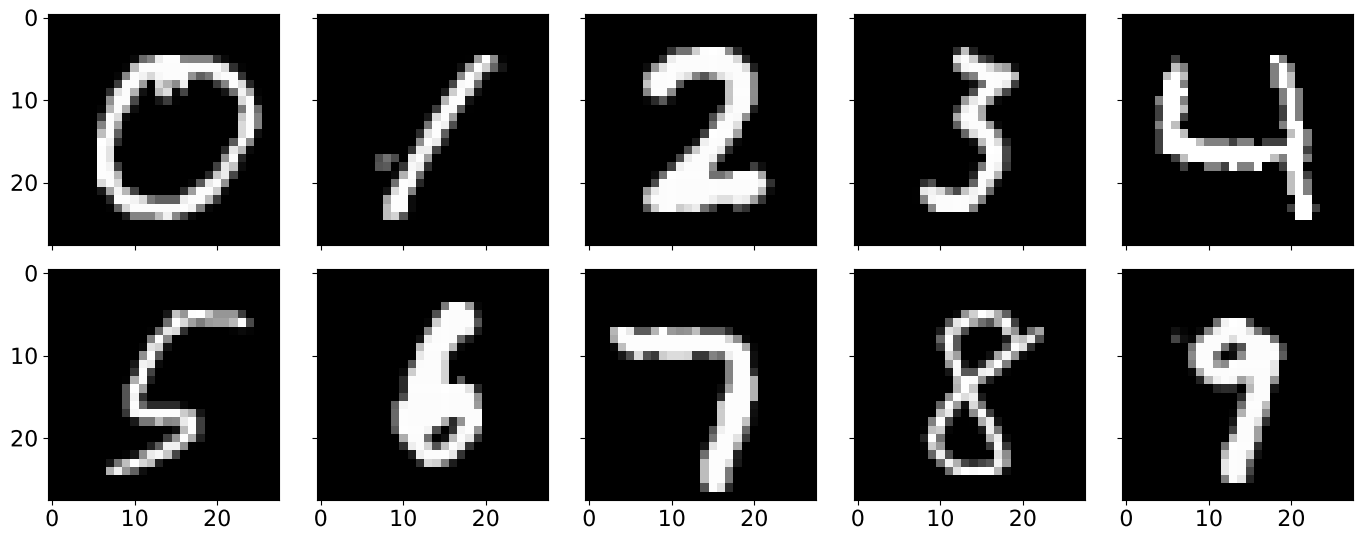

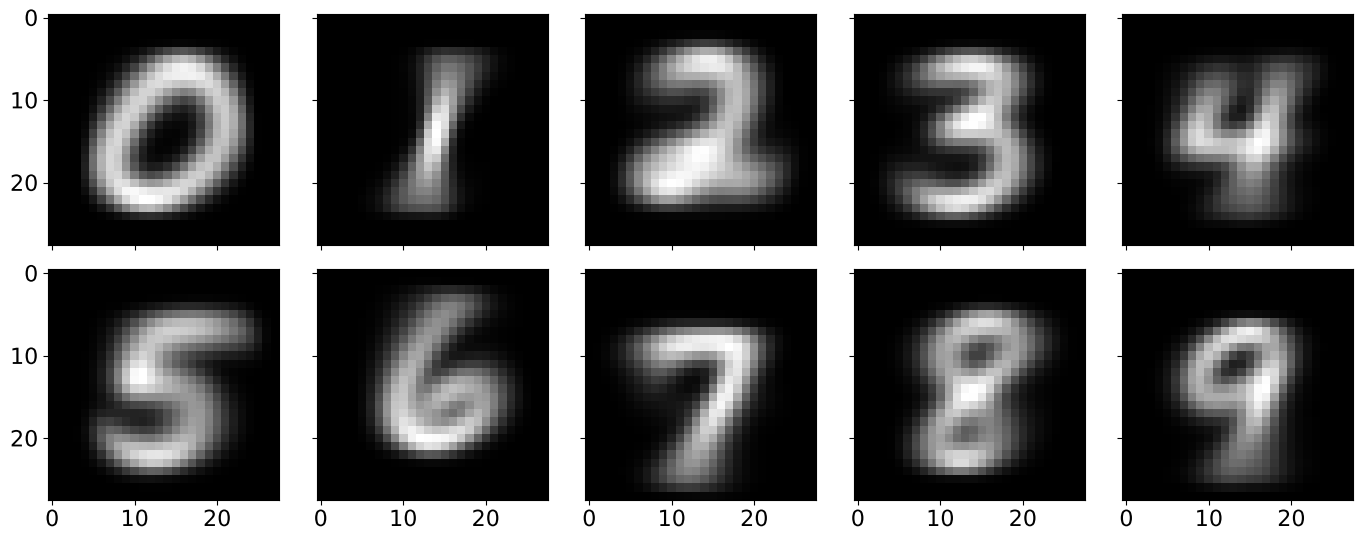

[6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958]

In [5]:
plot_image(mnist_ones, num_channels=1, normalize=False, filename='mnist_ones.png', distribution=(2, 5))
plot_image(mnist_avgs, num_channels=1, normalize=False, filename='mnist_avgs.png', distribution=(2, 5))
mnist_ns

In [6]:
qg_ones, qg_avgs, qg_ns = get_one_and_avg(get_quark_gluon_dataloaders(data_dir=data_dir), num_classes=2)

Cardinalities (train, val, test): 714510 79390 139306


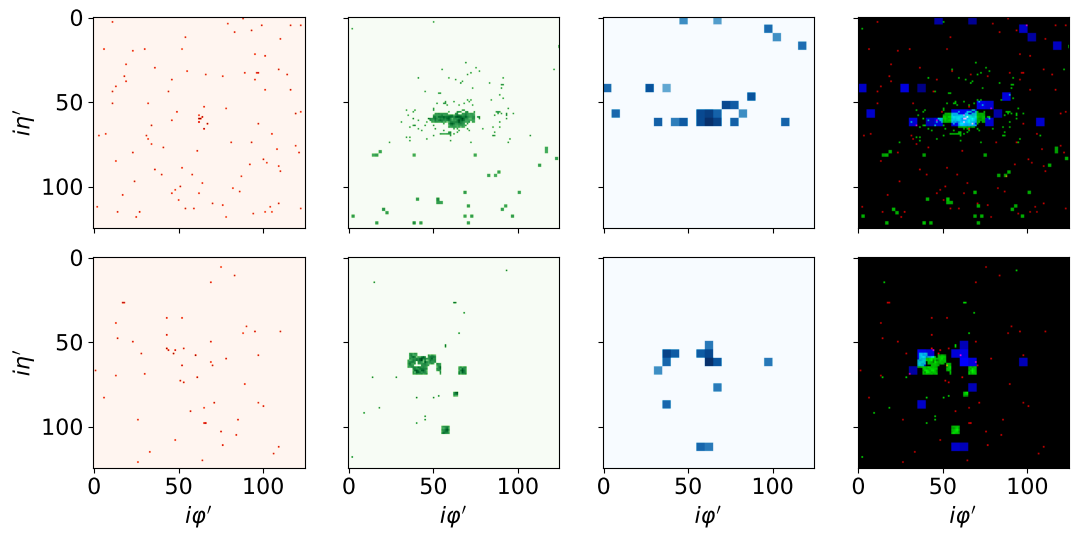

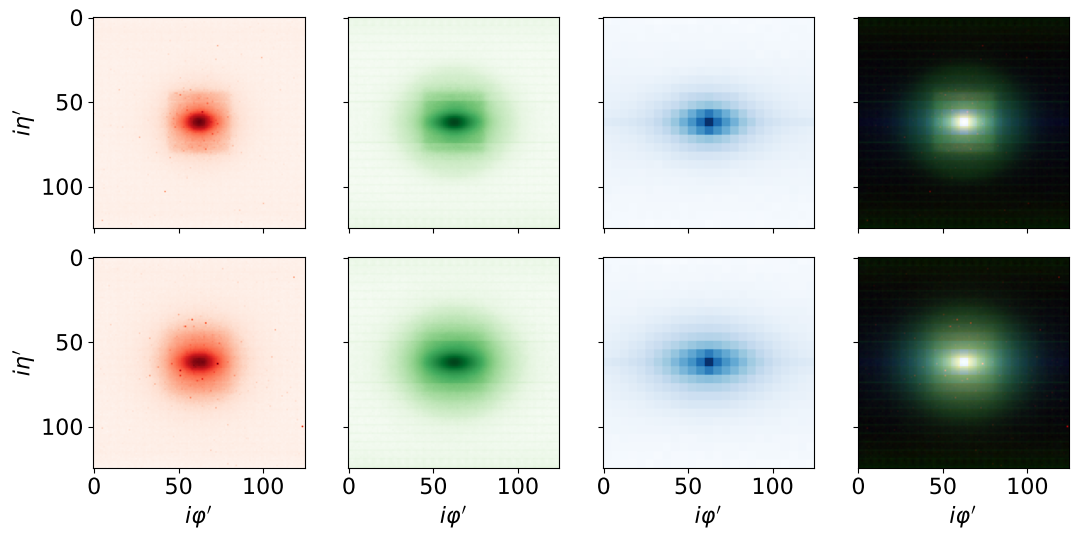

[466603, 466603]

In [7]:
plot_image(qg_ones, filename='qg_ones.png', y_label=r"$i\eta'$", x_label=r"$i\varphi'$")
plot_image(qg_avgs, filename='qg_avgs.png', y_label=r"$i\eta'$", x_label=r"$i\varphi'$")
qg_ns

In [8]:
ep_ones, ep_avgs, ep_ns = get_one_and_avg(get_electron_photon_dataloaders(data_dir=data_dir), num_classes=2)

Cardinalities (train, val, test): 439200 48800 10000


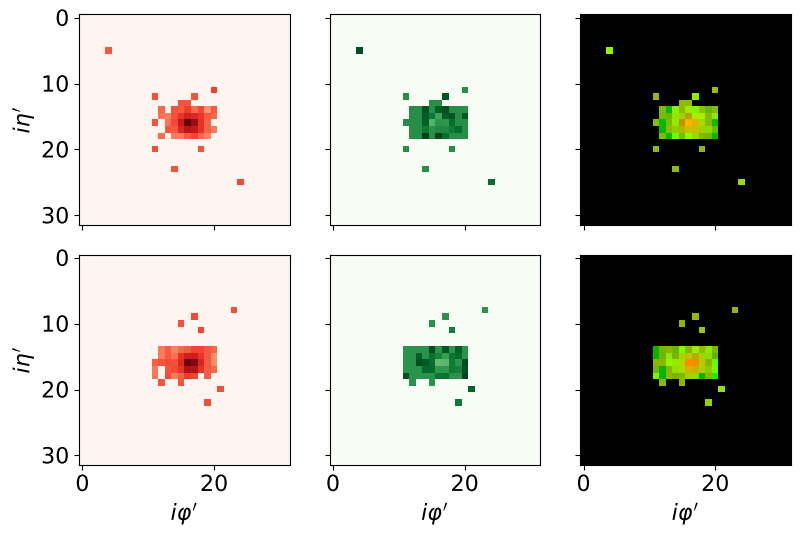

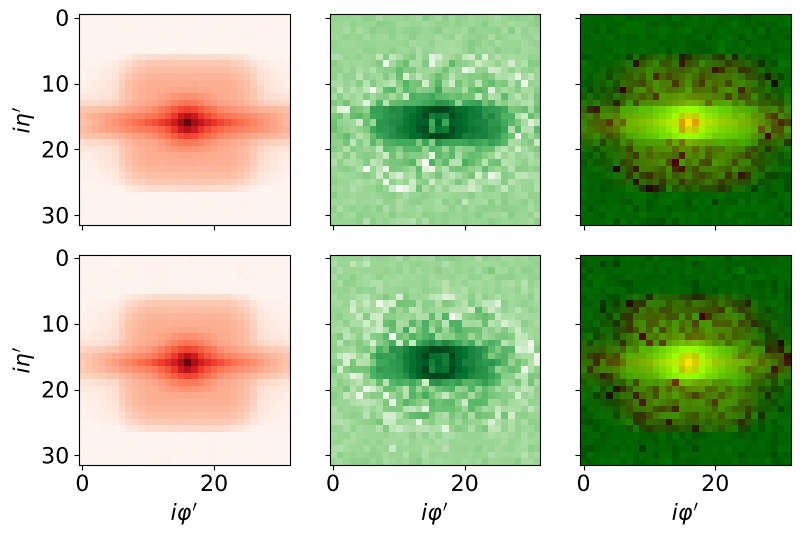

[249000, 249000]

In [9]:
plot_image(ep_ones, filename='ep_ones.png', num_channels=2, y_label=r"$i\eta'$", x_label=r"$i\varphi'$")
plot_image(ep_avgs, filename='ep_avgs.png', num_channels=2, y_label=r"$i\eta'$", x_label=r"$i\varphi'$")
ep_ns

---

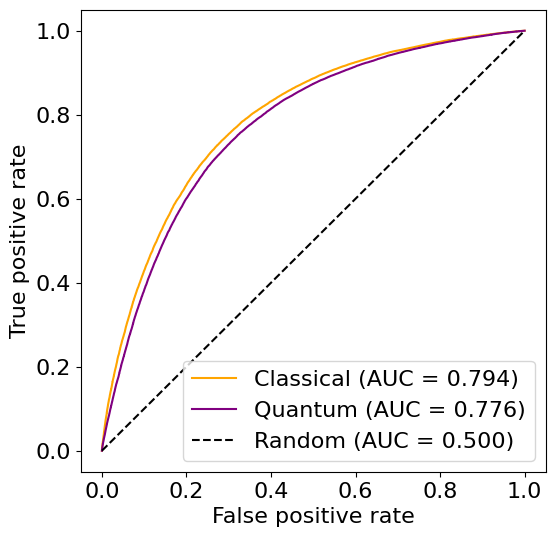

In [ ]:
import pickle

with open('../classical/qg_pr.pkl', 'rb') as f:
    classical_fpr, classical_tpr, classical_auc = pickle.load(f)

with open('../quantum/qg_pr.pkl', 'rb') as f:
    quantum_fpr, quantum_tpr, quantum_auc = pickle.load(f)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(classical_fpr, classical_tpr, label=f'Classical (AUC = {classical_auc:.3f})', color='orange')
ax.plot(quantum_fpr, quantum_tpr, label=f'Quantum (AUC = {quantum_auc:.3f})', color='purple')
ax.plot([0, 1], [0, 1], label=f'Random (AUC = 0.500)', color='black', linestyle='--')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend()